#### Importing the libaries

In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


### 1. Problem Statement

Predict the trend of Bitcoin closing price using a multivariate recurrent Neural Network(LSTM), by leveraging the historical Bitcoin closing price, open prices, high prices and low prices spanning the past 5 years.

### 2. Input Data

The input data is extracted from Yahoo Finance for Bitcoin (symbol = 'BTC-USD') using yfinance for the past 5 years in the date range from '2018-05-01' to '2023-06-14'.

In [2]:
stock = ['BTC-USD']
start = pd.to_datetime('2018-05-01')
end = pd.to_datetime('2023-05-15')
df = yf.download(stock, start = start,end=end )
print(df.head())

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-04-30  9426.110352  9477.139648  9166.809570  9240.549805  9240.549805   
2018-05-01  9251.469727  9255.879883  8891.049805  9119.009766  9119.009766   
2018-05-02  9104.599609  9256.519531  9015.139648  9235.919922  9235.919922   
2018-05-03  9233.969727  9798.330078  9188.150391  9743.860352  9743.860352   
2018-05-04  9695.500000  9779.200195  9585.959961  9700.759766  9700.759766   

                 Volume  
Date                     
2018-04-30   8673920000  
2018-05-01   7713019904  
2018-05-02   7558159872  
2018-05-03  10207299584  
2018-05-04   8217829888  


In [3]:
df.head(100)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-30,9426.110352,9477.139648,9166.809570,9240.549805,9240.549805,8673920000
2018-05-01,9251.469727,9255.879883,8891.049805,9119.009766,9119.009766,7713019904
2018-05-02,9104.599609,9256.519531,9015.139648,9235.919922,9235.919922,7558159872
2018-05-03,9233.969727,9798.330078,9188.150391,9743.860352,9743.860352,10207299584
2018-05-04,9695.500000,9779.200195,9585.959961,9700.759766,9700.759766,8217829888
...,...,...,...,...,...,...
2018-08-03,7562.140137,7562.140137,7328.649902,7434.390137,7434.390137,4627150000
2018-08-04,7438.669922,7497.490234,6984.069824,7032.850098,7032.850098,4268390000
2018-08-05,7031.080078,7102.770020,6940.700195,7068.479980,7068.479980,3679110000


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-10,27654.636719,28322.687500,26883.669922,27621.755859,27621.755859,20656025026
2023-05-11,27621.085938,27621.941406,26781.826172,27000.789062,27000.789062,16724343943
2023-05-12,26987.662109,27055.646484,25878.429688,26804.990234,26804.990234,19313599897
2023-05-13,26807.769531,27030.482422,26710.873047,26784.078125,26784.078125,9999171605
2023-05-14,26788.974609,27150.976562,26661.355469,26930.638672,26930.638672,10014858959


In [5]:
df.shape

(1841, 6)

In [6]:
df1 = df.sort_values(by=['Date']).copy()

# List of considered Features
feature_cols = ['High', 'Low', 'Open', 'Close']
print(feature_cols)

['High', 'Low', 'Open', 'Close']


In [7]:
# Create the dataset with features and filter the data to the list of FEATURES
data1 = pd.DataFrame(df1)
data = data1[feature_cols]
print(data.shape)

(1841, 4)


In [8]:
# We add a prediction column and set dummy values to prepare the data for scaling

data_pred = data.copy()
data_pred['Prediction'] = data['Close']


In [9]:
data_pred.tail()

,High,Low,Open,Close,Prediction
Date,,,,,
2023-05-10,28322.687500,26883.669922,27654.636719,27621.755859,27621.755859
2023-05-11,27621.941406,26781.826172,27621.085938,27000.789062,27000.789062
2023-05-12,27055.646484,25878.429688,26987.662109,26804.990234,26804.990234
2023-05-13,27030.482422,26710.873047,26807.769531,26784.078125,26784.078125
2023-05-14,27150.976562,26661.355469,26788.974609,26930.638672,26930.638672


#### 2.1 Visualizing the data

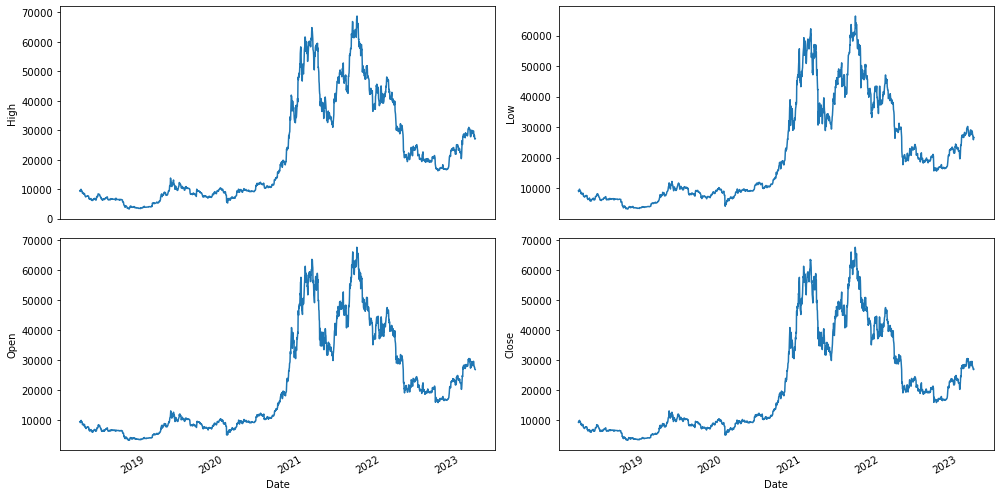

In [44]:
df_plot = data.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### 3. Data Pre-processing

#### 3.1 Feature Scaling

We use the MinMaxScaler to scale the input data to a range between 0 and 1.

In [10]:
# Convert the data to numpy values
data_unscaled = np.array(data)
np_data = np.reshape(data_unscaled, (data.shape[0], -1))
print(np_data.shape)

(1841, 4)


In [11]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_pred['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

#### 3.2 - Split the data

In [12]:
# Set the sequence length or window size for sliding window approach
sequence_length = 50

# Prediction Index
index_Close = data1.columns.get_loc("Close")

In [13]:
training_size = math.ceil(data_scaled.shape[0] * 0.8)

# Train data
train_data = data_scaled[0:training_size, :]
# Test data
test_data =  data_scaled[training_size - sequence_length:, :]

train_data.shape, test_data.shape

((1473, 4), (418, 4))

#### 3.3 Sliding Window Approach

A special data structure is designed using the sliging window approach to cover 50-time stamps, based on which RNN will predict the 51st price.

Here the number of past timestamps is set to 50 based on experimentation.

Thus, X_train is a nested list, which contains lists of 50 time-stamp prices(or mini-batches).

y_train is a list of stock prices which is the next day stock price i.e the 51st value, corresponding to each of the mini batches(of lists) in X_train.

In [14]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [15]:
# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [16]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1423, 50, 4) (1423,)
(368, 50, 4) (368,)


### 4. Model Building

First, we intialize a sequential model and then add the 1st LSTM layer consisting of 200 nuerons.
The number of neurons in the first layer must equal the size of a minibatch of the input data. Each minibatch in our dataset consists of a matrix with 50 steps and 4 features. Thus, the input layer of our recurrent neural network consists of 200 neurons.

return_sequences= True => passes on the sequences from one LSTM layer to the second LSTM layer.

input_shape => Corresponds to the timesteps and no of features of the train set which is 50 and 4 respectively

Dense is set to 1 since we are predicting the one closing price.

In [17]:
# Configure the neural network model
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]

print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dropout(0.2)) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(4))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

200 50 4


#### 4.1 Model Fitting

In [18]:

epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    

Epoch 1/50
89/89 [==============================] - 12s 70ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 2/50
89/89 [==============================] - 6s 66ms/step - loss: 0.0013 - val_loss: 7.7598e-04
Epoch 3/50
89/89 [==============================] - 8s 86ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/50
89/89 [==============================] - 7s 80ms/step - loss: 0.0013 - val_loss: 4.9480e-04
Epoch 5/50
89/89 [==============================] - 7s 84ms/step - loss: 8.9553e-04 - val_loss: 3.5302e-04
Epoch 6/50
89/89 [==============================] - 8s 93ms/step - loss: 8.7410e-04 - val_loss: 8.3787e-04
Epoch 7/50
89/89 [==============================] - 9s 99ms/step - loss: 8.8483e-04 - val_loss: 7.9730e-04
Epoch 8/50
89/89 [==============================] - 8s 95ms/step - loss: 8.6465e-04 - val_loss: 3.4018e-04
Epoch 9/50
89/89 [==============================] - 9s 97ms/step - loss: 7.5464e-04 - val_loss: 0.0021
Epoch 10/50
89/89 [==============================] - 9s 104ms/st

#### 4.2 Plot training & validation loss values

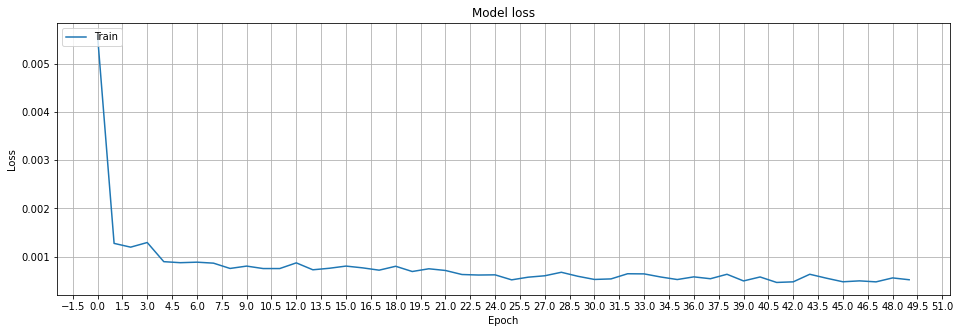

In [19]:

fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

**Inference:** The loss drops quickly to a lower plateau, which signals that the model has improved throughout the training process.

### 5. Making Predictions

In [20]:
# Get the predicted values

test_pred = model.predict(x_test)
test_pred[:5]

12/12 [==============================] - 2s 35ms/step


array([[0.40518305],
       [0.38902175],
       [0.3997713 ],
       [0.40821555],
       [0.42583987]], dtype=float32)

In [21]:
# Unscale the predicted values and the y_test data

predicted_stock_price = scaler_pred.inverse_transform(test_pred)

predicted_stock_price_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

### 6. Evaluate the model performance

In [45]:
ms_error = mean_squared_error(predicted_stock_price_unscaled, predicted_stock_price)
root_ms_error = math.sqrt(ms_error)
print('Root Mean Squared Error (MSE): %.3f' % root_ms_error)

Root Mean Squared Error (MSE): 822.362


**Inference**: We have used Root Mean Square Error(RMSE) as the error metric. RMSE signifies the average distance between predicted points on the test set and the actual (true) labels. In other words, it shows the extent of our error. The less this number, the better. We can see, that our model’s RMSE is not very big (consider that the price in our data set is in thousands of USD, and we are mistaken only by tens of USD).

### 7. Result Visualization

In [23]:
final_data = pd.concat([data.iloc[-368:].copy(),pd.DataFrame(predicted_stock_price,columns=['Close_Predicted'],index= data.iloc[-368:].index)], axis=1)

In [24]:
final_data['Close'] = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [25]:
final_data.head(100)

,High,Low,Open,Close,Close_Predicted
Date,,,,,
2022-05-12,30032.439453,26350.490234,28936.734375,29047.751953,29302.212891
2022-05-13,30924.802734,28782.330078,29030.910156,29283.103516,28262.556641
2022-05-14,30192.802734,28702.910156,29285.642578,30101.265625,28954.076172
2022-05-15,31308.191406,29527.740234,30098.585938,31305.113281,29497.294922
2022-05-16,31305.341797,29251.884766,31304.375000,29862.917969,30631.068359
...,...,...,...,...,...
2022-08-15,25135.589844,23839.775391,24318.316406,24136.972656,24854.634766
2022-08-16,24228.416016,23733.500000,24126.136719,23883.291016,24686.574219
2022-08-17,24407.058594,23243.353516,23881.316406,23335.998047,24333.312500


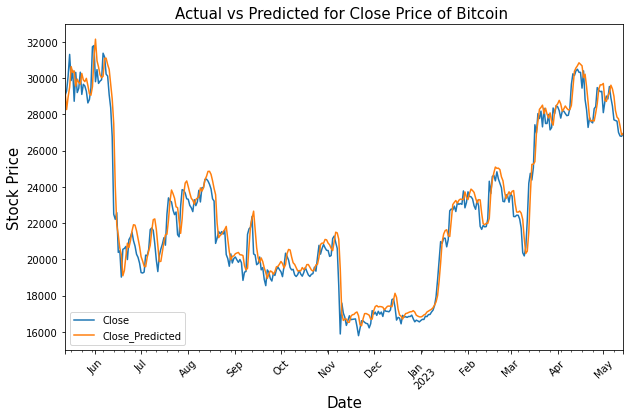

In [26]:
final_data[['Close','Close_Predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for Close Price of Bitcoin ',size=15)
plt.show()

**The plot shows that the forecast is close to the actual values but partially deviates from it. These deviations between actual values and predictions are called residuals.**